# Quantum Kernel Training for Machine Learning Applications

In this tutorial, we will train a quantum kernel on a labeled dataset for a machine learning application. To illustrate the basic steps, we will use Quantum Kernel Alignment (QKA) for a binary classification task. QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)


The entry point to training a quantum kernel is the `QuantumKernelTrainer` class. The basic steps are:

1. Prepare the dataset
2. Define the quantum feature map
3. Set up the `QuantumKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

### Import Local, External, and Qiskit Packages and define a callback class for our optimizer

In [1]:
# External imports
from pylab import cm
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        x[0]: number of function evaluations
        x[1]: the parameters
        x[2]: the function value
        x[3]: the stepsize
        x[4]: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### Prepare the Dataset

In this guide, we will use Qiskit Machine Learning's `ad_hoc.py` dataset, located [here](../../qiskit_machine_learning/datasets/), to demonstrate the kernel training process.

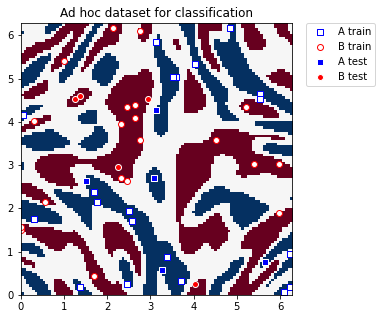

In [2]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### Define the Quantum Feature Map

Next, we set up the quantum feature map, which encodes classical data into the quantum state space. Here, we use a `QuantumCircuit` to set up a trainable rotation layer and a `ZZFeatureMap` from `Qiskit` to represent the input data.

In [3]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
user_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(user_params[0], 0)
fm0.ry(user_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


### Set Up the Quantum Kernel and Quantum Kernel Trainer

To train the quantum kernel, we need a `QuantumKernel` (holds the feature map and its parameters) and `QuantumKernelTrainer` (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, `SVCLoss`, as input to the `QuantumKernelTrainer`. Since this is a Qiskit-supported loss, we can use the string, `"svc_loss"`; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the `KernelLoss` object to the `QuantumKernelTrainer`.

We will select SPSA as the optimizer and initialize the trainable parameter with the `initial_point` argument. Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.

In [4]:
# Use the qasm simulator backend
backend = AerSimulator(method="statevector")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

### Train the Quantum Kernel

To train the quantum kernel on the dataset (samples and labels), we call the `fit_kernel` method of `QuantumKernelTrainer`.

In [5]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): -0.04578815645886802},
    'optimal_point': array([-0.04578816]),
    'optimal_value': 9.216619006529118,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f84b0603ee0>}


### Fit and Test the Model

We can pass the trained quantum kernel to a machine learning model, then fit the model and test on new data. Here, we will use Qiskit's `QSVC` for classification.

In [6]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 1.0


### Visualize the Kernel Training Process

From the callback data, we can plot how the loss evolves during the training process. We see it converges rapidly and reaches 100% test accuracy on this dataset with our choice of inputs.

We can also display the final kernel matrix evaluated on the training data.

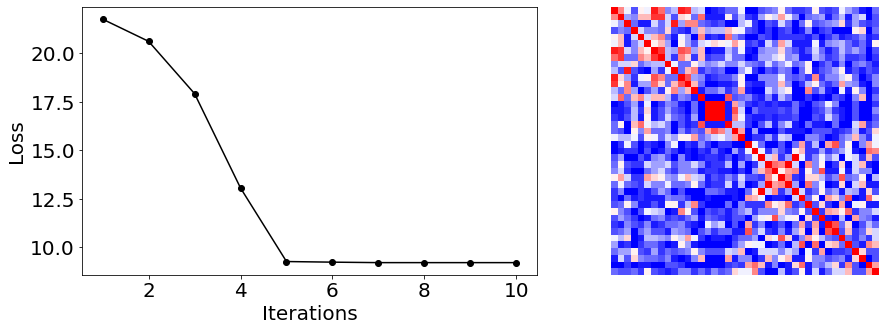

In [7]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
ax[1].axis("off")
fig.tight_layout()
plt.show()

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright